In [1]:
!pip3 install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 10.0 MB/s eta 0:00:00


In [35]:
from sklearn.model_selection import train_test_split
import xgboost
import shap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, roc_auc_score, brier_score_loss, average_precision_score
from scipy.stats import binomtest
from sklearn.calibration import calibration_curve

In [3]:
column_rename = pd.read_csv('/content/Column Rename.csv', encoding='utf-8')
rename_dict = dict(zip(column_rename['oldname'], column_rename['newname']))

In [4]:
training_set = pd.read_csv('/content/training_set.csv')
training_set.rename(columns=rename_dict, inplace=True)
training_set.shape

(39416, 170)

In [5]:
X_train = training_set.drop(columns=['death1yr'])
y_train = training_set['death1yr']

In [6]:
xgb_train_matrix = xgboost.DMatrix(X_train, label=y_train)

In [7]:
test_set = pd.read_csv('/content/test_set.csv')
test_set.rename(columns=rename_dict, inplace=True)
test_set.shape

(13122, 170)

In [8]:
X_test = test_set.drop(columns=['death1yr'])
y_test = test_set['death1yr']

In [9]:
xgb_test_matrix = xgboost.DMatrix(X_test, label=y_test)

In [10]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "aucpr",
    "lambda": 50,
    "gamma":5,
    'scale_pos_weight': y_train.value_counts()[0] / y_train.value_counts()[1]
}

In [11]:
random.seed(123)
xgb_model = xgboost.train(params, xgb_train_matrix, 5000, evals = [(xgb_test_matrix, "test")], verbose_eval=100, early_stopping_rounds=20)

[0]	test-aucpr:0.63326
[100]	test-aucpr:0.71583
[200]	test-aucpr:0.73973
[300]	test-aucpr:0.75278
[400]	test-aucpr:0.76084
[500]	test-aucpr:0.76608
[600]	test-aucpr:0.76866
[700]	test-aucpr:0.76992
[787]	test-aucpr:0.77030


In [12]:
y_prob = xgb_model.predict(xgb_test_matrix, output_margin=False)
y_pred = np.where(y_prob>=0.5,1,0)

In [13]:
#To compute 95% CI for ROC AUC
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_prob), len(y_prob))
    if len(np.unique(y_test[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_test[indices], y_prob[indices])
    bootstrapped_scores.append(score)
    #print("Bootstrap #{} ROC area: {:0.4f}".format(i + 1, score))


sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 95% confidence interval
confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]

In [14]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("95% CI Confidence interval for ROC-AUC [{:0.3f} - {:0.3f}]".format(binomtest(sum(y_test == y_pred), len(y_test), p=0.5, alternative='two-sided').proportion_ci(confidence_level=0.95)[0], binomtest(sum(y_test == y_pred), len(y_test), p=0.5, alternative='two-sided').proportion_ci(confidence_level=0.95)[1]))
print("Precision:", f'{precision_score(y_test, y_pred):.3f}')
print("Recall:", round(recall_score(y_test, y_pred), 3))
print("Sensitivity:", round(tp / (tp + fn), 3))
print("Specificity:", round(tn / (tn + fp), 3))
print("F1-score:", round(f1_score(y_test, y_pred), 3))
print("ROC-AUC:", round(roc_auc_score(y_test, y_prob), 3))
print("95% CI Confidence interval for ROC-AUC [{:0.3f} - {:0.3f}]".format(confidence_lower, confidence_upper))
print("PR-AUC:", f'{average_precision_score(y_test, y_prob):.3f}')
print("Brier score:", round(brier_score_loss(y_test, y_prob), 3))

Accuracy: 0.781
95% CI Confidence interval for ROC-AUC [0.774 - 0.788]
Precision: 0.660
Recall: 0.732
Sensitivity: 0.732
Specificity: 0.806
F1-score: 0.695
ROC-AUC: 0.862
95% CI Confidence interval for ROC-AUC [0.856 - 0.867]
PR-AUC: 0.770
Brier score: 0.147


**Calibration Plot**

In [52]:
y_prob_xgboost = pd.DataFrame(y_prob, columns=['y_prob_xgboost']) 
y_prob_xgboost.to_csv('y_prob_xgboost.csv', index=False)
y_prob_xgboost.shape

(13122, 1)

In [55]:
df_catboost = pd.read_csv('y_prob_catboost.csv')
df_xgboost = pd.read_csv('y_prob_xgboost.csv')
df_rf = pd.read_csv('y_prob_rf.csv')

df_calibration = pd.concat([df_catboost, df_rf, df_xgboost], axis=1)
df_calibration = df_calibration.rename(columns={'y_prob_catboost': 'Catboost', 'y_prob_rf': 'Random Forest', 'y_prob_xgboost': 'XGBoost'})
df_calibration['Test'] = y_test

df_calibration.head()

Catboost  Random Forest   XGBoost  Test
0  0.172781          0.293  0.442883     0
1  0.034525          0.113  0.174127     0
2  0.056182          0.080  0.183378     0
3  0.037752          0.069  0.204162     0
4  0.027282          0.066  0.184029     0

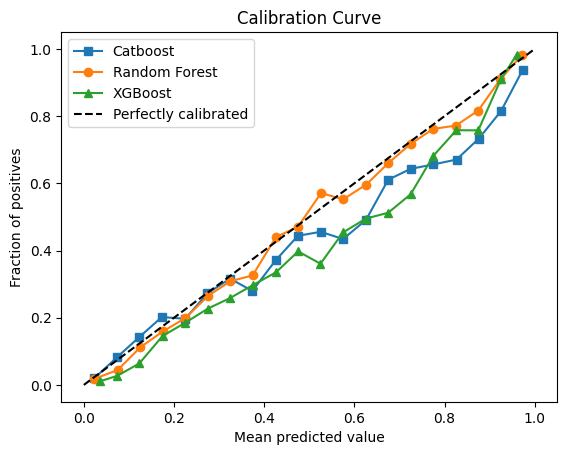

In [64]:
# calculate calibration curve for each model
frac_pos1, mean_pred_val1 = calibration_curve(df_calibration['Test'], df_calibration['Catboost'], n_bins=20)
frac_pos2, mean_pred_val2 = calibration_curve(df_calibration['Test'], df_calibration['Random Forest'], n_bins=20)
frac_pos3, mean_pred_val3 = calibration_curve(df_calibration['Test'], df_calibration['XGBoost'], n_bins=20)

# plot calibration curves
plt.plot(mean_pred_val1, frac_pos1, 's-', label='Catboost')
plt.plot(mean_pred_val2, frac_pos2, 'o-', label='Random Forest')
plt.plot(mean_pred_val3, frac_pos3, '^-', label='XGBoost')

# plot reference line
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')

# set plot parameters
plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.ylim([-0.05, 1.05])
plt.legend()
plt.title('Calibration Curve')

plt.show()

**SHAP Explainer**

In [15]:
explainer = shap.TreeExplainer(xgb_model, X_train,  model_output='probability', feature_perturbation = "interventional") #No more feature_dependence="independent"

In [16]:
shap_values = explainer.shap_values(X_train)

100%|===================| 39415/39416 [42:29<00:00]       

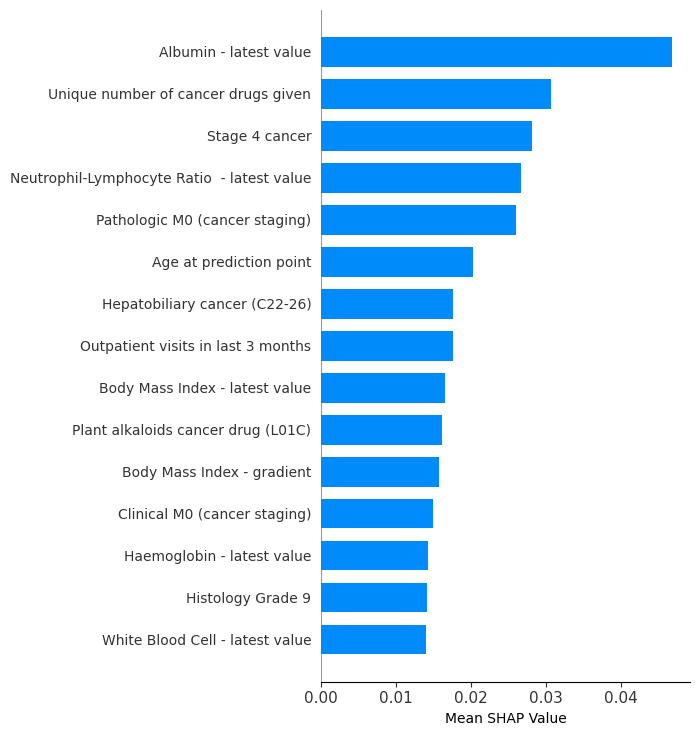

In [17]:
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=15, show=0, plot_size=0.4)
plt.xlabel('Mean SHAP Value', fontsize=10) #Average impact on model output
plt.yticks(fontsize=10)
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


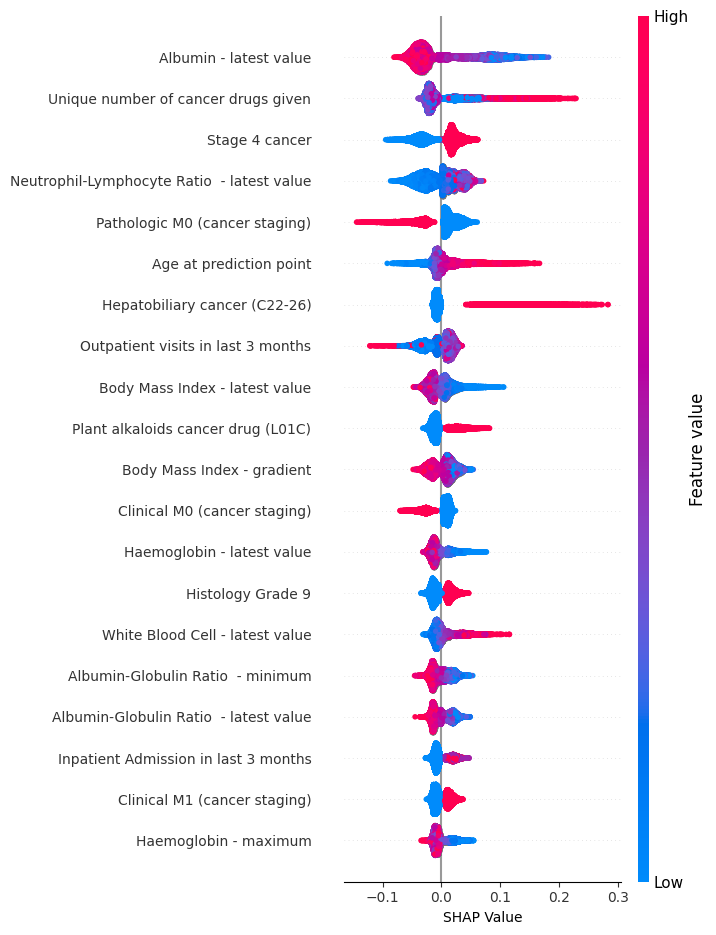

In [18]:
shap.summary_plot(shap_values, X_train, show=0)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.xlabel('SHAP Value', fontsize=10) #Average impact on model output
plt.show()

**Negative Example**

In [19]:
test_row = 156

In [20]:
print("Actual Output:", y_test.iloc[test_row])
print("Predicted XGBoost Probability:", y_prob[test_row])

Actual Output: 0
Predicted XGBoost Probability: 0.34490934


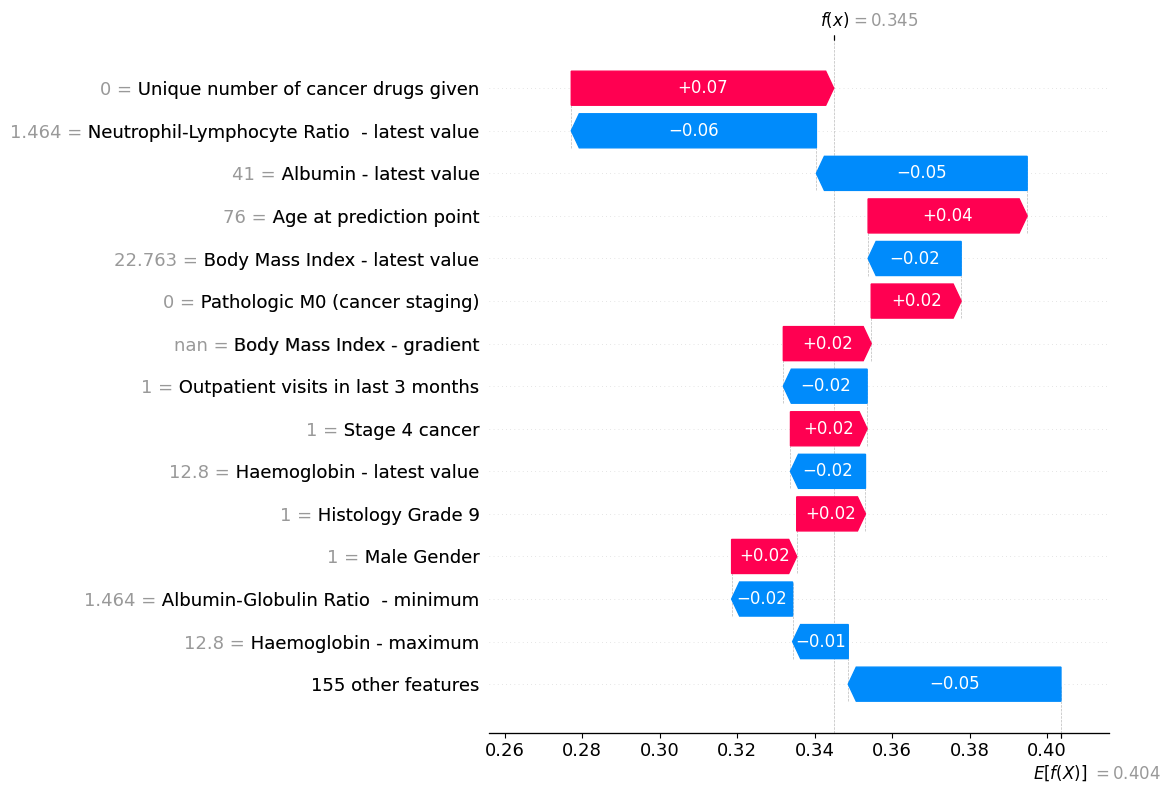

In [21]:
shap_values2 = explainer(X_test.iloc[test_row].to_frame().T)
shap.plots.waterfall(shap_values2[0], max_display=15)

In [22]:
shap.initjs()
shap.plots.force(shap_values2[0])

**Positive Example**

In [28]:
test_row = 156

In [29]:
print("Actual Output:", y_test.iloc[test_row])
print("Predicted XGBoost Probability:", y_prob[test_row])

Actual Output: 0
Predicted XGBoost Probability: 0.34490934


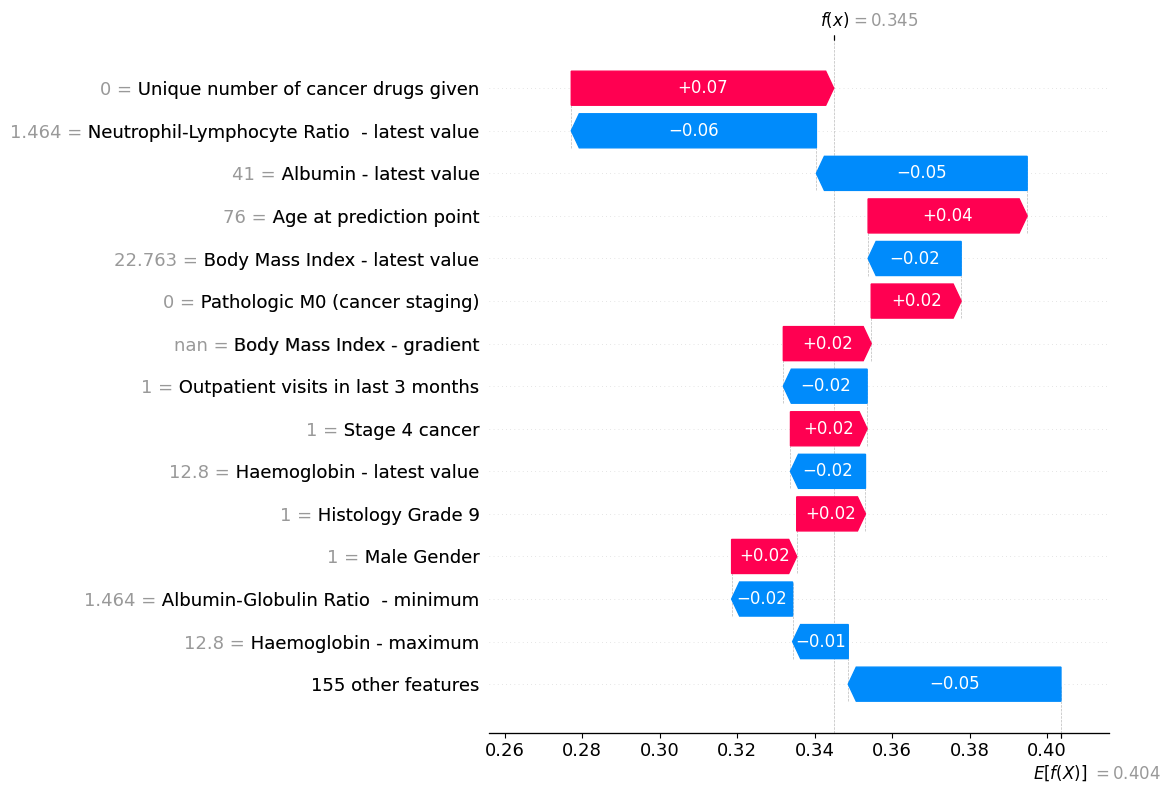

In [30]:
shap_values2 = explainer(X_test.iloc[test_row].to_frame().T)
shap.plots.waterfall(shap_values2[0], max_display=15)

In [26]:
shap.initjs()
shap.plots.force(shap_values2[0])

**Disconnect**

In [33]:
#Code to prevent disconnecting from colab
while True:
  ans = input("Stop Pause? (Y to exit)")
  if ans and ans[0].lower() == 'y':
    break

Stop Pause? (Y to exit)Y
